
#  Обсчёт АБ-теста (продление подписки)

Есть сервис, который работает по подписке (онлайн игра, стриминговый сервис, например). Один из важных факторов успешности бизнеса в таком случае - это удержание пользователей, необходимо придумать, как заинтересовать пользователя в продлении подпсики. Возникла идея дать скидку в $1\%$ на продление подписки. Чтобы оценить эфект от этой идеи мы разбили пользователей, которые купили подписку за период теста, на две группы и одним дали скидку на продление, а другим нет.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sts
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [3]:
df1 = pd.read_csv('subscribers_1.csv', sep=',')
print(df1.shape)
df1.head( )

(25935, 10)


,user_id,service_id,product_name,product_duration,rn,sale_date,last_duration_days,new_duration_days,is_same,group
0,47233,929,subscription,1_month,1,2018-12-21,30.0,30,1,0
1,50195,929,subscription,1_month,1,2019-03-17,30.0,30,1,1
2,62594,929,subscription,1_month,1,2019-02-08,30.0,30,1,0
3,68918,929,subscription,1_month,2,2019-03-19,30.0,30,1,1
4,91900,929,subscription,3_month,1,2018-10-29,30.0,90,0,0


* `rn` - порядковый номер покупки подписки за период.  
* `last_duration_days` - длительность предыдущей подписки.
* `new_duration_days` - длительность текущей подписки.
* `is_same` - менялась ли длительность подписки.
* `group` - группа теста, в которую попал пользователь. 1 - тест, 0 - контроль.

Найдем разницу между старой и новой длительностями подписки. Построим для этой разницы гистограмму. 
- Можно ли воспользоваться предпосылкой о нормальности распределения приростов и проверить гипотезу тестом Уэлча? 
- Переменная, для которой мы проводим тест имеет дискретное распределение. Можно ли здесь использовать тест Манна-Уитни? Даст ли это корректный результат? 
- Будет ли корректно использовать для проверки гипотезы ЦПТ и тест о равенстве средних, основанный на ней? 

<AxesSubplot:>

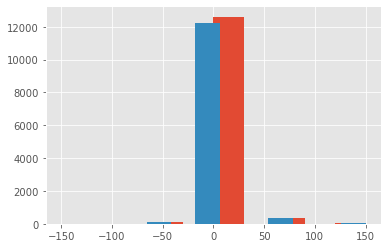

In [4]:
test = df1[df1['group'] == 1]['new_duration_days'] - df1[df1['group'] == 1]['last_duration_days']
control = df1[df1['group'] == 0]['new_duration_days'] - df1[df1['group'] == 0]['last_duration_days']

test.hist()
control.hist()

In [5]:
test.var(ddof=1), control.var(ddof=1)

(235.96558230270895, 246.07324870295517)

In [6]:
len(test), len(control)

(13144, 12791)

Распределение не очень похоже на нормальное, поэтому вряд ли можно воспользоваться тестом Уэлча. Также тест Уэлча корректен, если у нас выборка с большей дисперсией имеет больше наблюдений, а у нас наоборот - выборка с большей дисперсией имеет меньше наблюдений. Критерий Манна-Уитни предполагает, что распределения одинаковые и различаются только сдвигом. Это накладывает дополнительные ограничения, поэтому скорее всего также даст некорректный результат, потому что наши распределения визуально немного отличаются (в районе пика). ЦПТ использовать можно, у нас достаточно много наблюдений (хотя по гистограме видим наличие некоторых аномалий)

Правда ли, что средняя длительность подписки изменилась на $1\%$ уровне значимости? Для ответа на этот вопрос воспользуемся асимптотическим тестом на равенство средних против двусторонней альтернативы. Сохраним в переменную `z_obs` получившееся значение статистики, а в `pvalue` получившееся $p$-значение.

In [9]:
test = df1[df1['group'] == 1]['new_duration_days'] - df1[df1['group'] == 1]['last_duration_days']
control = df1[df1['group'] == 0]['new_duration_days'] - df1[df1['group'] == 0]['last_duration_days']

test_mean = test.mean()
control_mean = control.mean()

diff = control_mean - test_mean

test_var = test.var(ddof=1)
control_var = control.var(ddof=1)

ntest = len(test)
ncontrol = len(control)

z_obs = diff/np.sqrt(test_var/ntest + control_var/ncontrol)
pvalue = 2*(1 - sts.norm().cdf(np.abs(z_obs)))

z_obs, pvalue

(0.7476223219884844, 0.4546879966908093)

In [12]:
# через пакет
from statsmodels.stats.weightstats import ztest
z_obs, p_val = ztest(control, test, value=0)
z_obs, p_val

(0.7478357337395317, 0.4545592453826257)

__Вывод:__ Гипотеза о равенстве средних не отвергается, это говорит о том, что скидка в 1% незначительно изменила ситуацию с оформлением подписок 

## Проведем ААБ тест (2 контрольные группы и одна тестовая).

In [9]:
df2 = pd.read_csv('subscribers_2.csv', sep=',')
print(df2.shape)
df2.head( )

(25935, 10)


,user_id,service_id,product_name,product_duration,rn,sale_date,last_duration_days,new_duration_days,is_same,new_group
0,47233,929,subscription,1_month,1,2018-12-21,30.0,30,1,0
1,50195,929,subscription,1_month,1,2019-03-17,30.0,30,1,2
2,62594,929,subscription,1_month,1,2019-02-08,30.0,30,1,0
3,68918,929,subscription,1_month,2,2019-03-19,30.0,30,1,2
4,91900,929,subscription,3_month,1,2018-10-29,30.0,90,0,0


* `new_group` - группа теста, в которую попал пользователь. $2$ - тест, $0,1$ - контроль.

Проверим гипотезу о том, что в каждой из контрольных групп среднее совпадает с тестовой на уровне значимости $1\%$. Получившиеся $p$-значения запишем в переменные `pval_1` и `pval_2`. Сделаем корректировку методом Холма. Запишем количество отвергнутых гипотез в переменную `hyp_cnt`. 

In [10]:
from statsmodels.stats.weightstats import ztest
from statsmodels.sandbox.stats.multicomp import multipletests 
df2['d'] = df2['new_duration_days'] - df2['last_duration_days']
df_agg = df2.groupby('new_group')['d'].agg(lambda w: list(w))

x = np.array(df_agg[0])
y = np.array(df_agg[1])
z = np.array(df_agg[2])

alpha = 0.01
_, pval_1 = ztest(x, z, value=0)
_, pval_2 = ztest(y, z, value=0)

rejected, p_cor, _, _ = multipletests(np.array([pval_1, pval_2]), alpha = 0.01, method = 'holm') 
hyp_cnt = np.sum(p_cor < alpha)
pval_1, pval_2, hyp_cnt

(0.4472077983686553, 0.33226233074704103, 0)

> __Выводы:__ обе гипотезы не отвергаются (то есть средние не отличаются как между первой контрольной группой и тестовой, так и между второй и тестовой).
<p> Поправкой Холма мы увеличили первое р-значение еще "сильнее", не отвергли первую гипотезу (с наименьшим р-значением) и автоматически не отвергли все остальные. Поправка Холма пытается контролировать вероятность совершить хотя бы одну ошибку первого рода (то есть контролирует вероятность отвержения гипотезы, когда она на самом деле верна). По сути поправка увеличила р-значение, чтобы более уверенно не отвергнуть гипотезу, но мы ее и так не отвергли. Скорее всего, тут нет особого смысла делать эту поправку.